# LSTM을 활용하여 카카오 주가 예측하기

* 필요한 Library
    * yfinance :
        * yahoo finance [[ref]](https://github.com/ranaroussi/yfinance)
        * conda install yfinance
    * fbprophet : 
        * 시계열 데이터로 예측을 하기 위한 모듈 [[ref]](https://facebook.github.io/prophet/)
        * pip3 install fbprophet
    * pandas_datareader 
        * 웹 상의 데이터를 DataFrame 객체로 만드는 함수를 포함하는 모듈 [[ref]](https://pandas-datareader.readthedocs.io/en/latest/)
        * pip3 install pandas_datareader
    * pandas, numpy, seaborn, sklearn, tensorflow

* Reference
    * https://dschloe.github.io/python/python_edu/07_deeplearning/deep_learning_lstm/
    * https://bziwnsizd.tistory.com/33
    * https://coding-yoon.tistory.com/131
    * https://colab.research.google.com/github/teddylee777/machine-learning/blob/master/04-TensorFlow2.0/01-%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90-%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1/02-LSTM-stock-forecasting-with-LSTM-financedatareader.ipynb
    * https://dataplay.tistory.com/19
    * https://github.com/KerasKorea/KEKOxTutorial/blob/master/22_Keras%EB%A5%BC%20%ED%99%9C%EC%9A%A9%ED%95%9C%20%EC%A3%BC%EC%8B%9D%20%EA%B0%80%EA%B2%A9%20%EC%98%88%EC%B8%A1.md
    * https://www.youtube.com/watch?v=LLLVYkXJw30&t=843s
    * https://www.youtube.com/watch?v=9haME49Rx_0&t=120s

## Preparation

In [1]:
import os, sys  
from google.colab import drive  
# drive.mount('/content/drive')   
pg_path = '/content/packages'  
# os.symlink('/content/drive/My Drive/Colab Notebooks', pg_path)  
sys.path.insert(0, pg_path)  
# !pip install --target=$pg_path yfinance
# !pip install --target=$pg_path pingouin


In [2]:
!pip install --target=$pg_path pingouin

  Using cached pingouin-0.5.0-py3-none-any.whl
  Using cached statsmodels-0.13.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)
  Using cached scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.1 MB)
  Using cached pandas-1.3.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
  Using cached scikit_learn-1.0.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (24.8 MB)
  Using cached numpy-1.21.5-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Using cached tabulate-0.8.9-py3-none-any.whl (25 kB)
  Using cached matplotlib-3.5.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached pandas_flavor-0.2.0-py2.py3-none-any.whl (6.6 kB)
  Using cached outdated-0.2.1-py3-none-any.whl (7.5 kB)
  Using cached pyparsing-3.0.7-py3-none-any.whl (98 kB)
  Using cached fonttools-4.28.5-py3-none-any.whl (890 kB)
  Using cached cycler

In [3]:
# unitility
import os, warnings
from copy import deepcopy
from datetime import datetime

# stock price data load
import yfinance as yf

# data handling
import pandas as pd
from pandas_datareader import data as dfr
import numpy as np

# modeling
import sklearn  # from sklearn import preprocessing, feature_selection, linear_model, svm, metrics, model_selection
import tensorflow as tf
from fbprophet import Prophet

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
from IPython.core.display import display, HTML
from IPython.display import Image

In [4]:
#plot setting
plt.style.use('seaborn')  # plt.style.use('ggplot')
sns.set(font_scale=1.5)

plt.rc('font', family='AppleGothic') 
plt.rcParams['figure.figsize'] = [10, 5]
mpl.rcParams['axes.unicode_minus'] = False  

%matplotlib inline

#ignore warnings
warnings.filterwarnings('ignore') # 워닝 메세지를 생략해 줍니다. 차후 버전관리를 위해 필요한 정보라고 생각하시면 주석처리 하시면 됩니다.

In [5]:
# path setting
proj_dir = os.getcwd()
# data_dir = (os.getcwd() +  '/titanic')
os.chdir(proj_dir)

## Load Data

In [6]:
yf.pdr_override()

In [7]:
start_date= "2020-01-01"
end_date="2022-01-22"

In [8]:
kko = dfr.get_data_yahoo(tickers = '035720.KS', start = start_date, end = end_date)

[*********************100%***********************]  1 of 1 completed


## Glimpse

In [9]:
kko.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,30800.0,30900.0,30400.0,30500.0,30487.734375,1205235
2020-01-03,30700.0,31000.0,30200.0,30500.0,30487.734375,1574240
2020-01-06,30100.0,31000.0,30000.0,30900.0,30887.574219,1968575


In [10]:
kko.describe()

,Open,High,Low,Close,Adj Close,Volume
count,510.000000,510.000000,510.000000,510.000000,510.000000,5.100000e+02
mean,88797.843137,90259.019608,87427.647059,88813.529412,88802.771415,4.211166e+06
std,38159.554588,38660.398239,37581.765219,38038.688212,38046.470298,2.887414e+06
min,27600.000000,29400.000000,25500.000000,26800.000000,26789.222656,0.000000e+00
25%,61500.000000,63775.000000,60850.000000,62025.000000,62000.056641,2.255909e+06
50%,86950.000000,88750.000000,85500.000000,87750.000000,87750.000000,3.475121e+06
75%,120000.000000,121875.000000,118000.000000,119500.000000,119500.000000,5.113046e+06
max,172000.000000,173000.000000,161000.000000,169500.000000,169500.000000,1.889515e+07


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


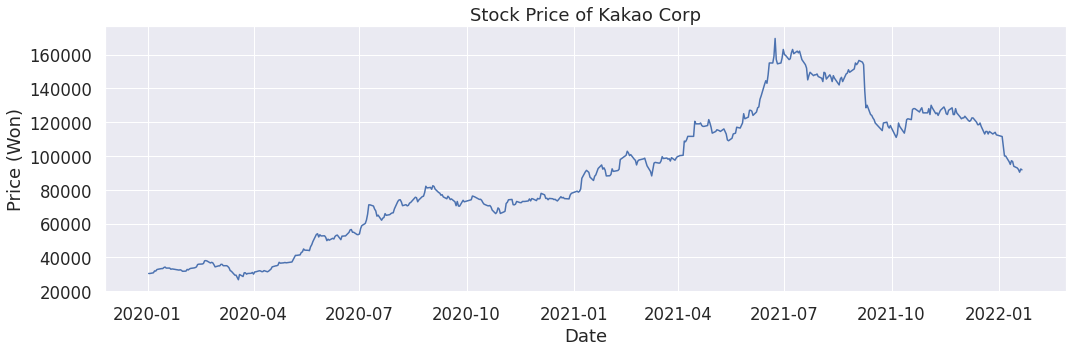

In [11]:
plt.figure(figsize=[15,5])
g1 = sns.lineplot(data = kko, x='Date', y='Close')
g1.set_ylabel('Price (Won)')
g1.set_xlabel('Date')
g1.set_title('Stock Price of Kakao Corp')
plt.tight_layout()
plt.show()

## "fbprophet" library로 Forecasting 하기

### Data Split

In [12]:
df = deepcopy(kko)
train_df = df[:'2021-10-01'].filter(['Close']).reset_index()
test_df = df['2021-10-01':].filter(['Close']).reset_index()

In [13]:
print(train_df.shape, test_df.shape)

(434, 2) (77, 2)


* Prophet에 사용하기 위해 날짜를 ds, 종가를 y로 바꾸어준다.

In [16]:
train_df.columns = ['ds', 'y']
test_df.columns = ['ds', 'y']

### Modeling

* fbprophet 라이브러리의 Prophet API 사용 [[ref]](https://hyperconnect.github.io/2020/03/09/prophet-package.html)
* help(Prophet)

In [17]:
model = Prophet(yearly_seasonality=True, daily_seasonality=True, weekly_seasonality=True)

In [18]:
model.fit(train_df)

### Prediction

In [19]:
mid = datetime.strptime('2021-10-01', "%Y-%m-%d")
end = datetime.strptime(end_date, "%Y-%m-%d")
date_diff = end - mid
date_diff.days

113

In [20]:
future_day = model.make_future_dataframe(periods=date_diff.days)
pred_df = model.predict(future_day)

In [21]:
print(pred_df.shape)
pred_df.head(3)

(547, 22)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-02,34758.943664,25174.454701,35619.124324,34758.943664,34758.943664,-4237.162600,-4237.162600,-4237.162600,17734.345054,17734.345054,17734.345054,924.700948,924.700948,924.700948,-22896.208602,-22896.208602,-22896.208602,0.0,0.0,0.0,30521.781064
1,2020-01-03,34622.613501,25343.768826,35836.818167,34622.613501,34622.613501,-3948.761949,-3948.761949,-3948.761949,17734.345054,17734.345054,17734.345054,753.315898,753.315898,753.315898,-22436.422902,-22436.422902,-22436.422902,0.0,0.0,0.0,30673.851552
2,2020-01-06,34213.623011,26422.564400,37285.551966,34213.623011,34213.623011,-2666.806074,-2666.806074,-2666.806074,17734.345054,17734.345054,17734.345054,686.588252,686.588252,686.588252,-21087.739381,-21087.739381,-21087.739381,0.0,0.0,0.0,31546.816937


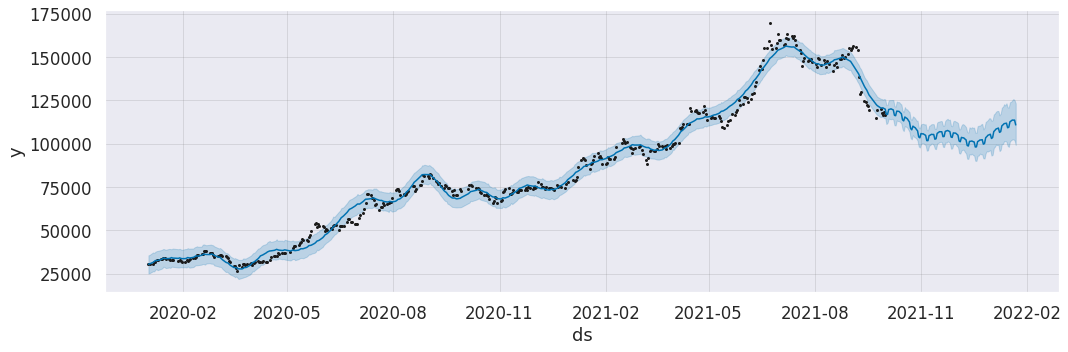

In [22]:
model.plot(pred_df[["ds", "yhat", "yhat_lower", "yhat_upper"]], figsize=(15, 5));

### Performance Check

* 

In [23]:
df_tmp = deepcopy(df.reset_index())
df_tmp = df_tmp.filter(['Date', 'Close', 'High', 'Low'])
df_tmp.columns = ['ds', 'y', 'High', 'Low']

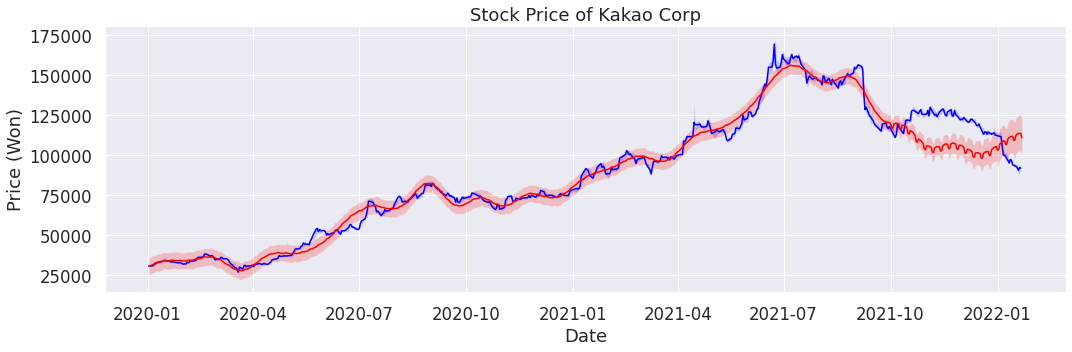

In [24]:
plt.figure(figsize=[15,5])
g1 = sns.lineplot(data = df_tmp, x='ds', y='y', color='blue')
g1.fill_between(data= df_tmp, x='ds', y1='Low', y2='High', 
                facecolor='blue', alpha=0.2)

g1 = sns.lineplot(data = pred_df, x='ds', y='yhat', color='red')
g1.fill_between(data= pred_df, x='ds', y1='yhat_lower', y2='yhat_upper', 
                facecolor='red', alpha=0.2)
g1.set_ylabel('Price (Won)')
g1.set_xlabel('Date')
g1.set_title('Stock Price of Kakao Corp')
plt.tight_layout()
plt.show()

In [25]:
predicted = pd.merge(pred_df, test_df, how = 'right')[['ds','yhat','y']]

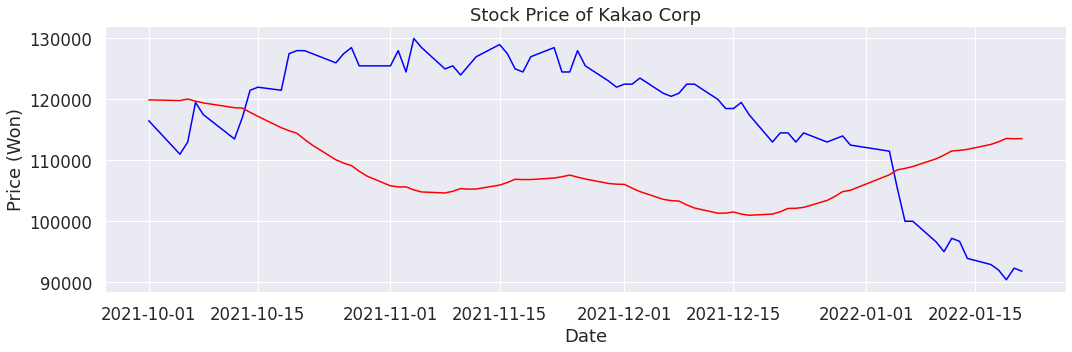

In [26]:
plt.figure(figsize=[15,5])
g1 = sns.lineplot(data = predicted, x='ds', y='y', color='blue')
g1 = sns.lineplot(data = predicted, x='ds', y='yhat', color='red')
g1.set_ylabel('Price (Won)')
g1.set_xlabel('Date')
g1.set_title('Stock Price of Kakao Corp')
plt.tight_layout()
plt.show()

In [27]:
from sklearn import metrics
print('mse :', metrics.mean_squared_error(predicted.y, predicted.yhat))
print('mae :', metrics.mean_absolute_error(predicted.y, predicted.yhat))

mse : 264194501.41645688
mae : 15089.661446381999


In [28]:
import pingouin as pg
pg.corr(predicted.y, predicted.yhat,
        alternative="two-sided",
        method="pearson") # pearson, spearman, kendall, bicor, percbend, shepherd, skipped

,n,r,CI95%,p-val,BF10,power
pearson,77,-0.265084,"[-0.46, -0.04]",0.019811,2.042,0.651517


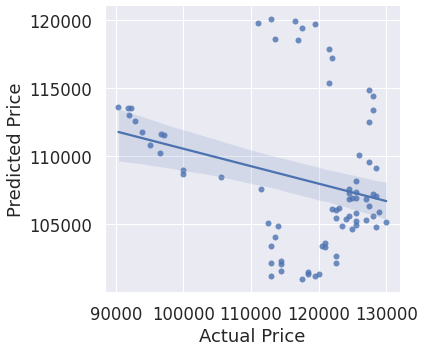

In [29]:
g = sns.lmplot(x="y", y="yhat", data=predicted, height=5, aspect=1.2);
g.set_axis_labels("Actual Price", "Predicted Price")
plt.tight_layout()
plt.show()

## LSTM으로 Forecasting 하기

### Data Preparation

In [81]:
df2 = deepcopy(kko)
df2 = df2.reset_index()

In [82]:
train_df = df2[:df2[df2.Date == '2021-10-01'].index[0]]
test_df = df2[df2[df2.Date == '2021-10-01'].index[0]:]

In [83]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
train_df = scaler.fit_transform(train_df[scale_cols])
train_df = pd.DataFrame(train_df)
train_df.columns = scale_cols

test_df = scaler.transform(test_df[scale_cols])
test_df = pd.DataFrame(test_df)
test_df.columns = scale_cols

In [89]:
train_df.shape, test_df.shape

((433, 7), (77, 7))

In [88]:
train_df = pd.concat([df2[:df2[df2.Date == '2021-10-01'].index[0]].reset_index().Date, train_df], axis = 1)
test_df = pd.concat([df2[df2[df2.Date == '2021-10-01'].index[0]:].reset_index().Date, test_df], axis = 1)

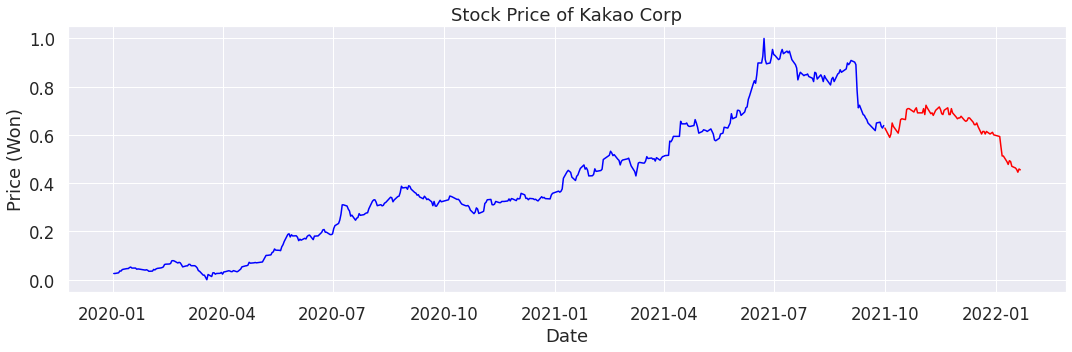

In [93]:
plt.figure(figsize=[15,5])
g1 = sns.lineplot(data = train_df, x='Date', y='Close', color='blue')
g1 = sns.lineplot(data = test_df, x='Date', y='Close', color='red')
g1.set_ylabel('Price (Won)')
g1.set_xlabel('Date')
g1.set_title('Stock Price of Kakao Corp')
plt.tight_layout()
plt.show()

In [94]:
def make_dataset(data, label, window_size=10):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [95]:
window_size=10
train_x = train_df[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
train_y = train_df['Close']
train_x, train_y = make_dataset(train_x, train_y, window_size)

test_x = test_df[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
test_y = test_df['Close']
test_x, test_y = make_dataset(test_x, test_y, window_size)

In [96]:
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(423, 10, 5) (423,)
(67, 10, 5) (67,)


In [97]:
train_x[0][0], train_y[0], train_df.loc[10,:]

(array([0.02216066, 0.01044568, 0.03616236, 0.06378542, 0.02591613]),
 0.052557813594954456,
 Date         2020-01-16 00:00:00
 Open                   0.0443213
 High                   0.0348189
 Low                    0.0627306
 Close                  0.0525578
 Adj Close              0.0525327
 Volume                 0.0688137
 Name: 10, dtype: object)

In [98]:
from sklearn import model_selection
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(train_x, train_y, test_size=0.2)
x_train.shape, x_valid.shape

((338, 10, 5), (85, 10, 5))

### Modeling

In [99]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

# model setting
model = keras.models.Sequential()
model.add(keras.layers.LSTM(16, 
               input_shape=(train_x.shape[1], train_x.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# callback setting
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')


In [100]:
history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
19/22 [========================>.....] - ETA: 0s - loss: 0.0752
Epoch 00001: val_loss improved from inf to 0.02206, saving model to model/tmp_checkpoint.h5
22/22 [==============================] - 2s 19ms/step - loss: 0.0696 - val_loss: 0.0221
Epoch 2/200
16/22 [====================>.........] - ETA: 0s - loss: 0.0140
Epoch 00002: val_loss improved from 0.02206 to 0.00537, saving model to model/tmp_checkpoint.h5
22/22 [==============================] - 0s 10ms/step - loss: 0.0122 - val_loss: 0.0054
Epoch 3/200
18/22 [=======================>......] - ETA: 0s - loss: 0.0023
Epoch 00003: val_loss improved from 0.00537 to 0.00113, saving model to model/tmp_checkpoint.h5
22/22 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 4/200
16/22 [====================>.........] - ETA: 0s - loss: 0.0011    
Epoch 00004: val_loss improved from 0.00113 to 0.00098, saving model to model/tmp_checkpoint.h5
22/22 [==============================] - 0s 10ms/

In [101]:
model.load_weights(filename)
pred_y = model.predict(test_x)
pred_y.shape

(67, 1)

In [131]:
predicted = pd.concat([test_df.Date[10:].reset_index(), 
                       pd.DataFrame(test_y, columns=['y']), 
                       pd.DataFrame(pred_y, columns=['yhat'])], 
                      axis=1, ignore_index=True)

predicted.columns = ['idx','ds','y','yhat']

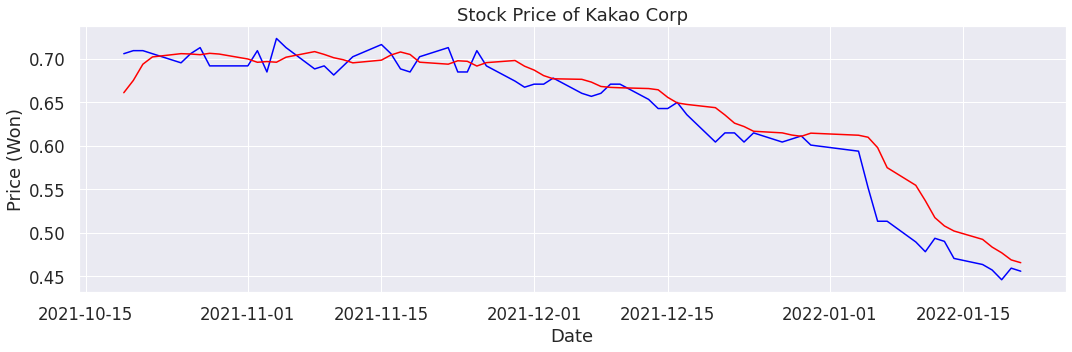

In [132]:
plt.figure(figsize=[15,5])
g1 = sns.lineplot(data = predicted, x='ds', y='y', color='blue')
g1 = sns.lineplot(data = predicted, x='ds', y='yhat', color='red')
g1.set_ylabel('Price (Won)')
g1.set_xlabel('Date')
g1.set_title('Stock Price of Kakao Corp')
plt.tight_layout()
plt.show()

In [133]:
from sklearn import metrics
print('mse :', metrics.mean_squared_error(predicted.y, predicted.yhat))
print('mae :', metrics.mean_absolute_error(predicted.y, predicted.yhat))

mse : 0.0006151104268635361
mae : 0.018549717949260365


In [134]:
import pingouin as pg
pg.corr(predicted.y, predicted.yhat,
        alternative="two-sided",
        method="pearson") # pearson, spearman, kendall, bicor, percbend, shepherd, skipped

,n,r,CI95%,p-val,BF10,power
pearson,67,0.971258,"[0.95, 0.98]",3.068555e-42,3.048e+38,1.0


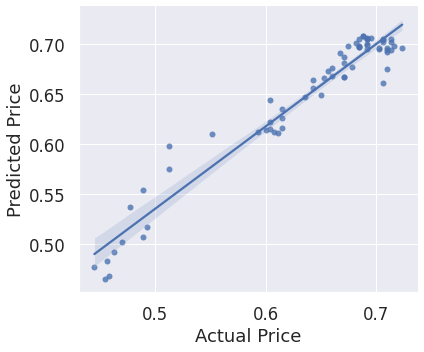

In [135]:
g = sns.lmplot(x="y", y="yhat", data=predicted, height=5, aspect=1.2);
g.set_axis_labels("Actual Price", "Predicted Price")
plt.tight_layout()
plt.show()

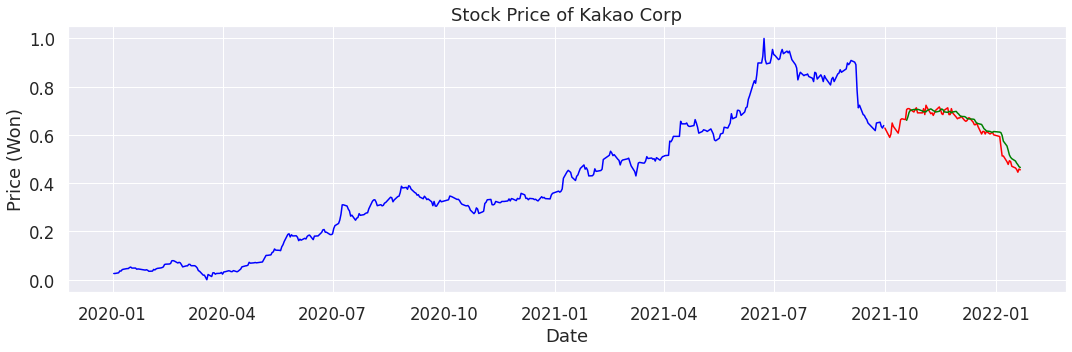

In [138]:
plt.figure(figsize=[15,5])
g1 = sns.lineplot(data = train_df, x='Date', y='Close', color='blue')
g1 = sns.lineplot(data = test_df, x='Date', y='Close', color='red')
g1 = sns.lineplot(data = predicted, x='ds', y='yhat', color='green')
g1.set_ylabel('Price (Won)')
g1.set_xlabel('Date')
g1.set_title('Stock Price of Kakao Corp')
plt.tight_layout()
plt.show()